# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [3]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [4]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [5]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [6]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Total_Spending,Total_Purchases,Total_Accepted,Customer_Days
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236,2236.000000,2236.00000,2236.000000,2236.000000,...,2236.000000,2236.000000,2236.0,2236.0,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,5589.008497,1968.898032,51952.614043,0.444097,0.506708,2013-07-10 05:26:30.697674,49.116279,304.12746,26.275939,166.983453,...,0.013417,0.008945,3.0,11.0,0.149374,55.101968,605.986583,12.546512,0.447227,353.773256
min,0.000000,1940.000000,1730.000000,0.000000,0.000000,2012-07-30 00:00:00,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,3.0,11.0,0.000000,28.000000,5.000000,0.000000,0.000000,0.000000
25%,2828.250000,1959.000000,35502.500000,0.000000,0.000000,2013-01-16 00:00:00,24.000000,24.00000,1.000000,16.000000,...,0.000000,0.000000,3.0,11.0,0.000000,47.000000,69.000000,6.000000,0.000000,180.750000
50%,5454.500000,1970.000000,51381.500000,0.000000,0.000000,2013-07-08 00:00:00,49.000000,174.00000,8.000000,67.000000,...,0.000000,0.000000,3.0,11.0,0.000000,54.000000,396.500000,12.000000,0.000000,356.000000
75%,8421.750000,1977.000000,68275.750000,1.000000,1.000000,2013-12-30 06:00:00,74.000000,504.25000,33.000000,232.000000,...,0.000000,0.000000,3.0,11.0,0.000000,65.000000,1045.500000,18.000000,1.000000,529.000000
max,11191.000000,1996.000000,162397.000000,2.000000,2.000000,2014-06-29 00:00:00,99.000000,1493.00000,199.000000,1725.000000,...,1.000000,1.000000,3.0,11.0,1.000000,84.000000,2525.000000,32.000000,5.000000,699.000000
std,3244.826887,11.703281,21411.466851,0.538459,0.544609,NaN,28.957284,336.59181,39.724007,225.689645,...,0.115077,0.094173,0.0,0.0,0.356536,11.703281,601.865156,7.206577,0.891113,202.181561


In [7]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균
target_cols = df[['Income', 'Total_Spending', 'Age']]
mean_val = target_cols.mean()
median_val = target_cols.median()
mode_val = target_cols.mode().iloc[0]
trimmed_5 = stats.trim_mean(target_cols, 0.05)
print(f'평균: {mean_val}')
print(f'중앙값: {median_val}')
print(f'최빈값: {mode_val}')
print(f'5% 절사평균: {trimmed_5}')

평균: Income            51952.614043
Total_Spending      605.986583
Age                  55.101968
dtype: float64
중앙값: Income            51381.5
Total_Spending      396.5
Age                  54.0
dtype: float64
최빈값: Income            51381.5
Total_Spending       46.0
Age                  48.0
Name: 0, dtype: float64
5% 절사평균: [51740.15342602   561.11966236    55.07497517]


In [8]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)
var_val = target_cols.var(ddof=1)
std_val = target_cols.std()
iqr_val = target_cols.quantile(0.75) - target_cols.quantile(0.25)
cv_val = (std_val / target_cols.mean()) * 100
print(f'분산: {var_val}')
print(f'표준편차: {std_val}')
print(f'IQR: {iqr_val}')
print(f'CV: {cv_val}')

분산: Income            4.584509e+08
Total_Spending    3.622417e+05
Age               1.369668e+02
dtype: float64
표준편차: Income            21411.466851
Total_Spending      601.865156
Age                  11.703281
dtype: float64
IQR: Income            32773.25
Total_Spending      976.50
Age                  18.00
dtype: float64
CV: Income            41.213454
Total_Spending    99.319881
Age               21.239315
dtype: float64


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

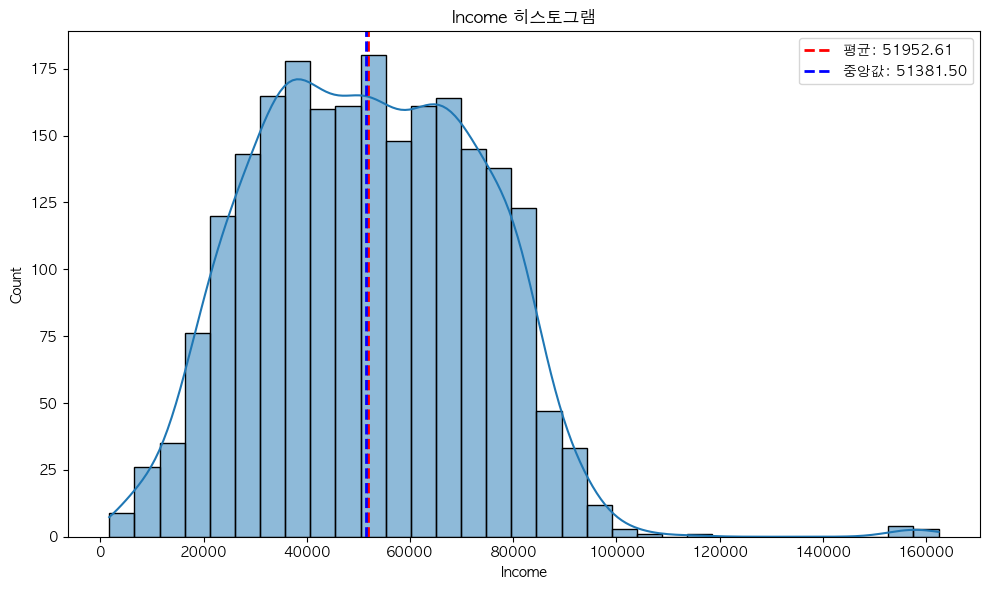

In [9]:
# TODO 1-2(a): Income 히스토그램 + KDE
mean_val = df['Income'].mean()
median_val = df['Income'].median()

fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(df['Income'], kde=True)

ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_val:.2f}')
ax.axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'중앙값: {median_val:.2f}')

ax.set_title('Income 히스토그램')
ax.legend()

plt.tight_layout()
plt.show()

lower 이상치 수: 0
upper 이상치 수: 3
IQR 기준 이상치: 3


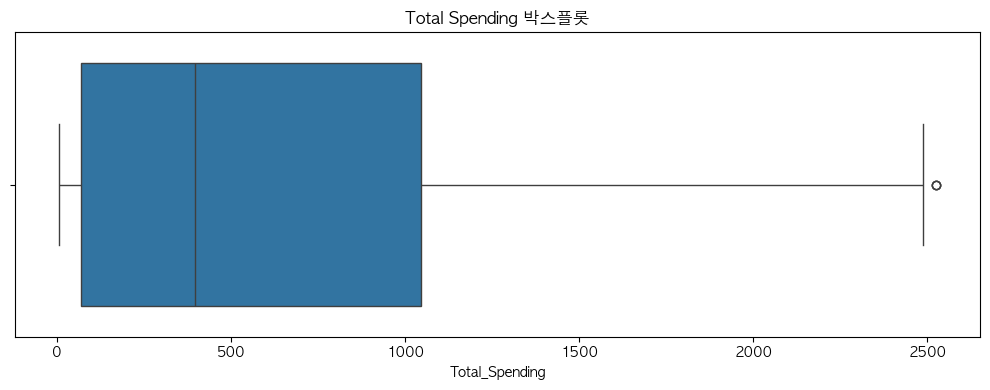

In [10]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치
fig, ax = plt.subplots(figsize=(10,4))

sns.boxplot(x=df['Total_Spending'],)
ax.set_title('Total Spending 박스플롯')

Q1 = df['Total_Spending'].quantile(0.25)
Q3 = df['Total_Spending'].quantile(0.75)
IQR = Q3 - Q1
iqr_lower = Q1 - 1.5 * IQR
iqr_upper = Q3 + 1.5 * IQR
lower_outliers = (df['Total_Spending'] < iqr_lower).sum()
upper_outliers = (df['Total_Spending'] > iqr_upper).sum()
total_outliers = lower_outliers + upper_outliers

print(f'lower 이상치 수: {lower_outliers}')
print(f'upper 이상치 수: {upper_outliers}')
print(f'IQR 기준 이상치: {total_outliers}')

plt.tight_layout()
plt.show()

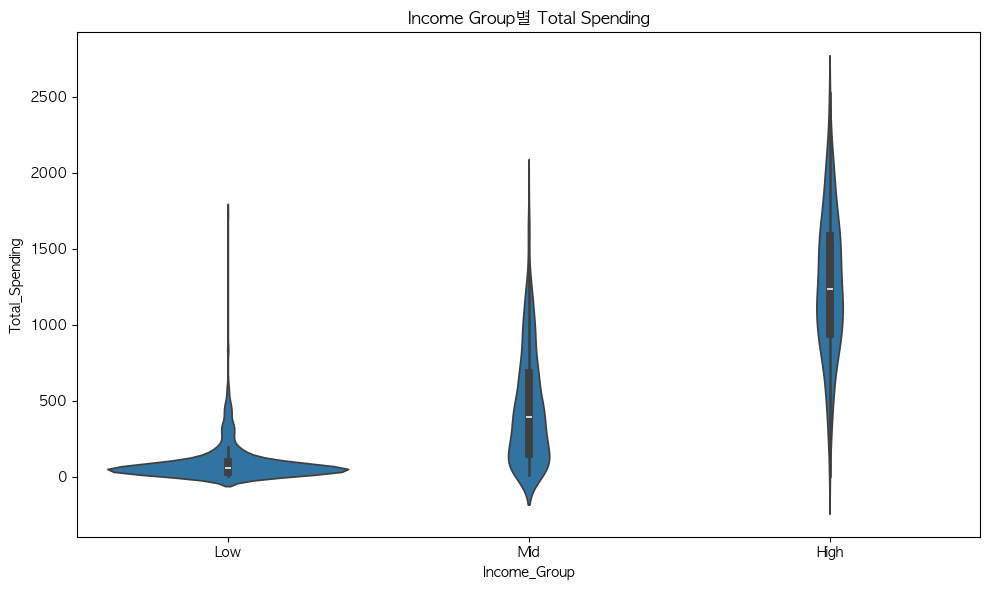

In [11]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(x='Income_Group', y='Total_Spending', data=df)
ax.set_title('Income Group별 Total Spending')

plt.tight_layout()
plt.show()

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [12]:
spending_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

skew_val = df[spending_cols].skew()
kurt_val = df[spending_cols].kurt()

print(f'왜도: {skew_val}')
print(f'첨도: {kurt_val}')

왜도: MntWines            1.176036
MntFruits           2.104241
MntMeatProducts     2.085282
MntFishProducts     1.919970
MntSweetProducts    2.135674
MntGoldProds        1.885136
dtype: float64
첨도: MntWines            0.600531
MntFruits           4.069754
MntMeatProducts     5.530136
MntFishProducts     3.096020
MntSweetProducts    4.372062
MntGoldProds        3.558349
dtype: float64


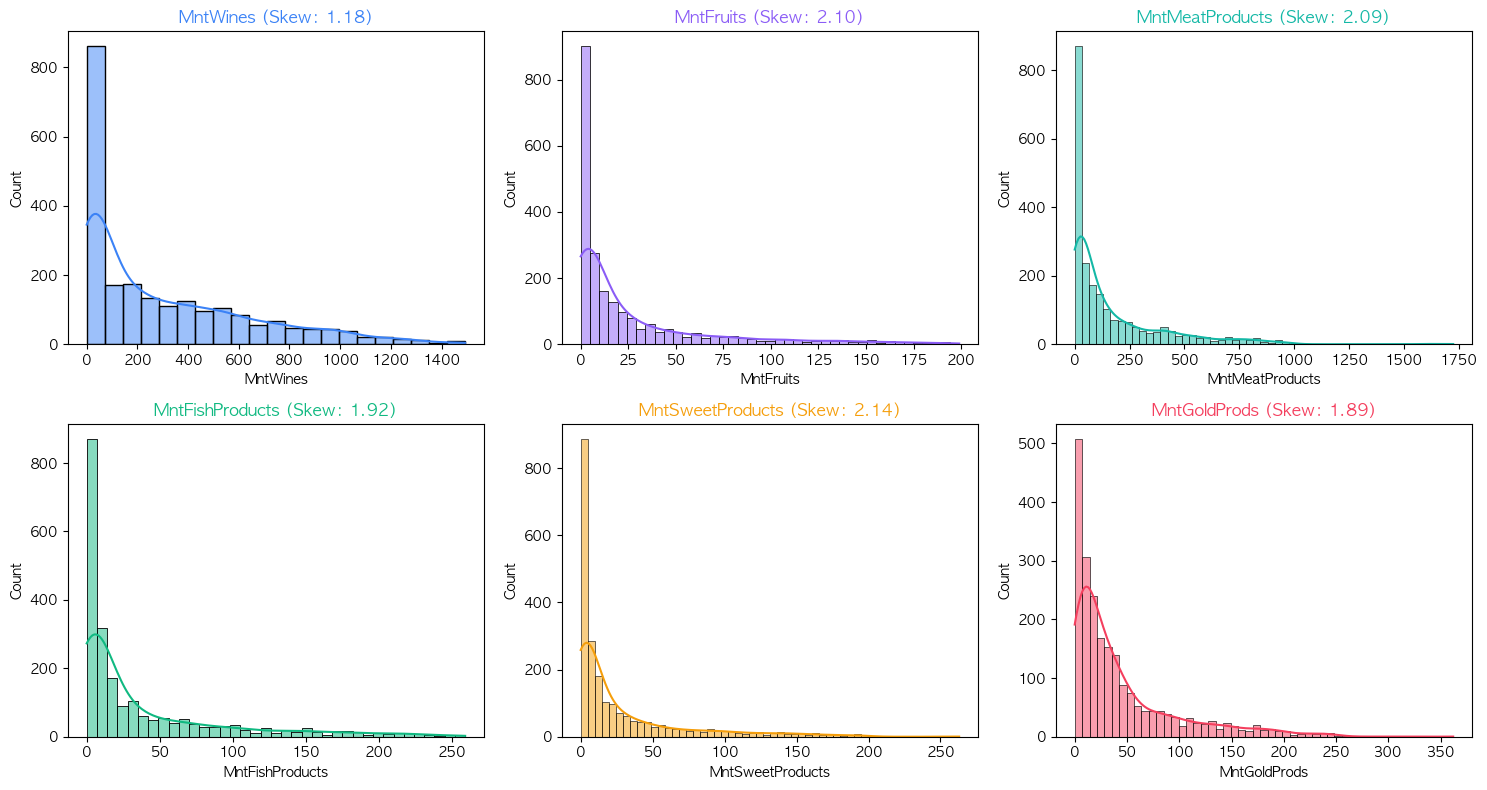

In [13]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(spending_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color=hist_colors[i])
    axes[i].set_title(f'{col} (Skew: {df[col].skew():.2f})', color=hist_colors[i], fontweight='bold')
    ax.legend()
plt.tight_layout()
plt.show()

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [14]:
# TODO 1-4: 비즈니스 인사이트 정리
# 평균 연령은 약 55세 평균 소득은 약 $52,000이며, 소득은 정규분포에 가깝지만 소비는 파레토형
# 소득은 고르게 퍼져 있지만, 소비는 평균이 중앙값보다 높음. 이는 소수의 큰손고객이 전체 매출을 견인하고 있음을 의미(오른쪽으로 꼬리가 긴 분포, 파레토 분포).
# 와인과 육류의 왜도가 매우 큼, 소비의 변동성이 매우 크다.
# (1) 소득이 높은 사람이 와인을 더 많이 구매할 것이다.
# (2) 자녀가 있는 고객은 자녀가 없는 고객보다 와인 구매가 적을 것이다.
# (3) 클레임을 걸었던 고객은 이번 캠페인 수략률이 많이 낮을 것이다.

---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [15]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10
p = df['Response'].mean()

binom_dist = stats.binom(n_trial, p)

p_exactly_2 = binom_dist.pmf(2)
print(f"\n(a) P(X = 2) = {p_exactly_2}")

p_at_least_3 = binom_dist.cdf(3)
print(f"(b) P(X >= 3) = {p_at_least_3}")


(a) P(X = 2) = 0.27521465499368986
(b) P(X >= 3) = 0.9506969473125981


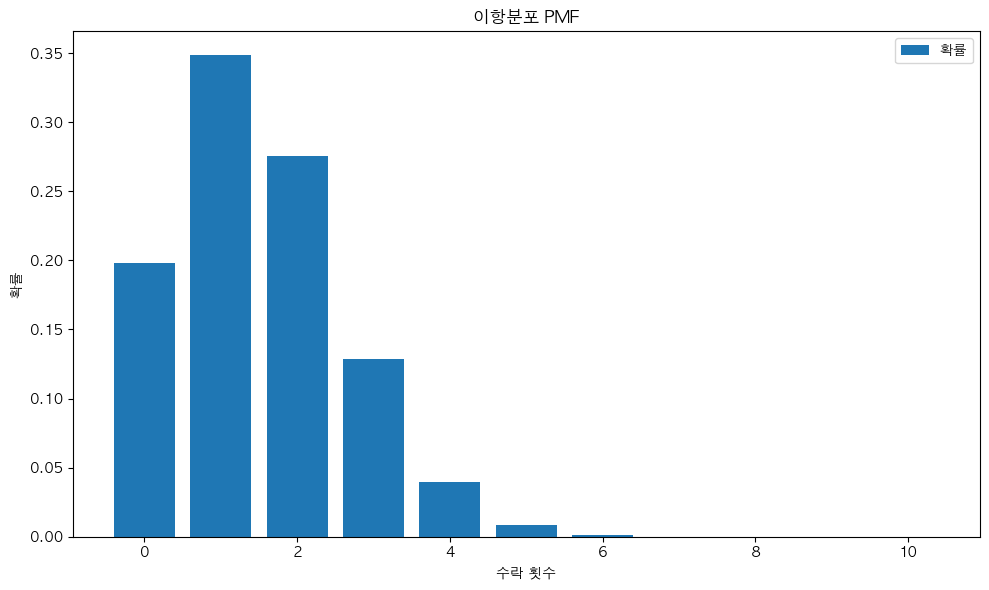

In [16]:
# TODO 2-1(c): 이항분포 PMF 시각화
fig, ax = plt.subplots(figsize=(10, 6))
k = np.arange(0, 11)
pmf = binom_dist.pmf(k)

ax.bar(k, pmf, label='확률')
ax.set_title('이항분포 PMF')
ax.set_xlabel('수락 횟수')
ax.set_ylabel('확률')
ax.legend()

plt.tight_layout()
plt.show()

In [17]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100
binom_100 = stats.binom(n_campaign, p)

exp_val = n_campaign * p
p_at_least_15 = binom_100.sf(14)
capacity_90 = binom_100.ppf(0.1)

print(f'기대 수락자 수: {exp_val}')
print(f'P(X >= 15): {p_at_least_15}')
print(f'90% 보장 최소 수락 수: {capacity_90}')

기대 수락자 수: 14.937388193202148
P(X >= 15): 0.5358059894078704
90% 보장 최소 수락 수: 10.0


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [18]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
lam = web_visits.mean()
var = web_visits.var()
ratio = var / lam
display(lam, var, ratio) # 1.1 포아송 적합

np.float64(5.318872987477639)

np.float64(5.889773404889684)

np.float64(1.1073348468286668)

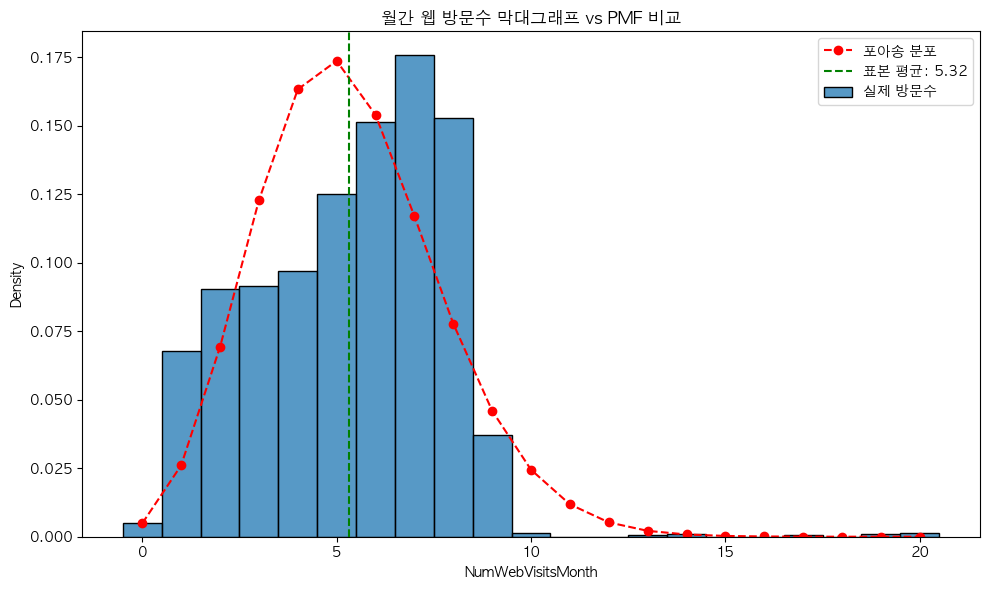

In [19]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
poisson_dist = stats.poisson(lam)

fig, ax = plt.subplots(figsize=(10, 6))
k = np.arange(0, web_visits.max() + 1)
pmf = poisson_dist.pmf(k)

sns.histplot(web_visits, discrete=True, stat='density', label='실제 방문수')

ax.plot(k, pmf, 'ro--', label='포아송 분포')
ax.axvline(lam, color='green', linestyle='--', label=f'표본 평균: {lam:.2f}')
ax.set_title('월간 웹 방문수 막대그래프 vs PMF 비교')
ax.legend()

plt.tight_layout()
plt.show()

In [20]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10
poisson_dist = stats.poisson(lam)

p_at_least_10 = poisson_dist.sf(9)
print(f"P(X ≥ 10) = {p_at_least_10}")

capacity_95 = poisson_dist.ppf(0.95)
print(f'상위 5%: {capacity_95}')

P(X ≥ 10) = 0.044918586974302156
상위 5%: 9.0


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [21]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교
mu = df['Income'].mean()
sigma = df['Income'].std()

norm_dist = stats.norm(loc=mu, scale=sigma)
print(f'P(Income < 30000) = {norm_dist.cdf(30000)}')
print(f'P(Income > 80000) = {norm_dist.sf(80000)}')
print(f'상위 10% 소득 기준값: {norm_dist.ppf(0.9)}')

P(Income < 30000) = 0.15261702861320564
P(Income > 80000) = 0.09511083952500893
상위 10% 소득 기준값: 79392.51290587384


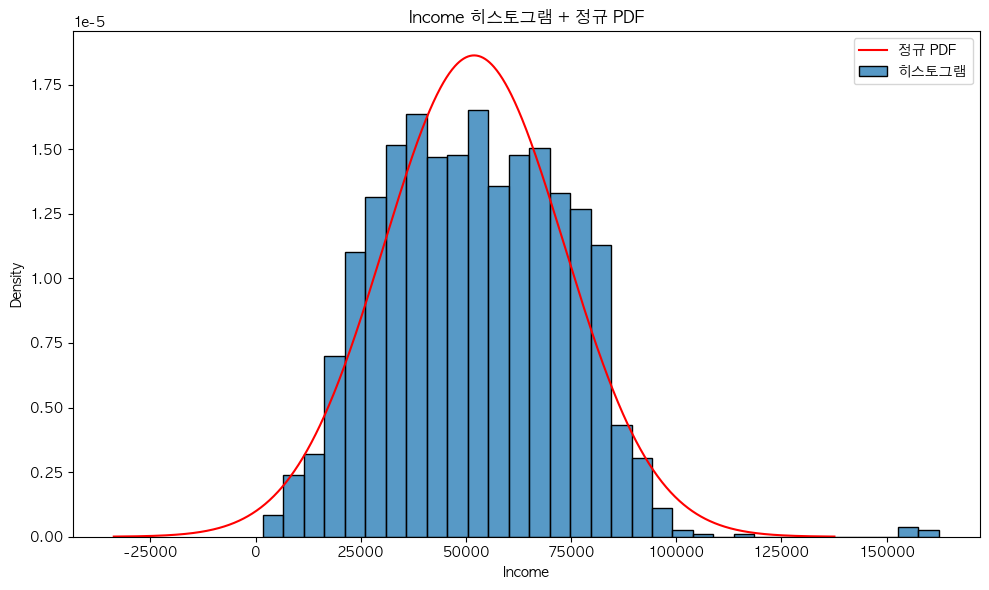

In [22]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기
fig, ax = plt.subplots(figsize=(10, 6))

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
pdf = norm_dist.pdf(x)

sns.histplot(df['Income'], stat='density', label='히스토그램')
ax.plot(x, pdf, 'r-', label='정규 PDF')
ax.set_title('Income 히스토그램 + 정규 PDF')
ax.legend()

plt.tight_layout()
plt.show()

In [23]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선
print(f'VIP 기준선: {norm_dist.ppf(0.95)} -> 이 금액 이상이면 VIP고객으로 분류')
print(f'할인 대상 기준선: {norm_dist.ppf(0.1)} -> 이 금액 이하이면 할인 대상 고객으로 분류')

VIP 기준선: 87171.34295042677 -> 이 금액 이상이면 VIP고객으로 분류
할인 대상 기준선: 24512.715179993782 -> 이 금액 이하이면 할인 대상 고객으로 분류


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [24]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE
target_data = df['Total_Spending']
mean = target_data.mean()
std = target_data.std(ddof=1)
n = len(target_data)
se = std / np.sqrt(n)
confidence_levels = [0.90, 0.95, 0.99]
for cl in confidence_levels:
    alpha = 1 - cl
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
    margin_of_error = t_crit * se
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    print(f"{int(cl*100)}% 신뢰구간: [{ci_lower:.2f}, {ci_upper:.2f}]")

90% 신뢰구간: [585.04, 626.93]
95% 신뢰구간: [581.03, 630.95]
99% 신뢰구간: [573.17, 638.80]


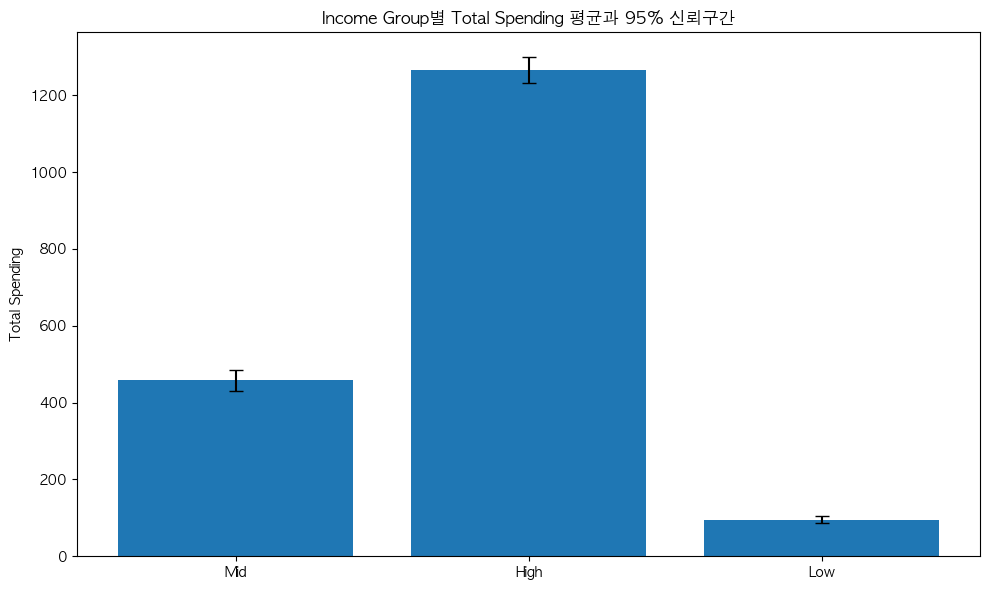

In [25]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프
income_groups = df['Income_Group'].unique()
ci_results = {}
for group in income_groups:
    group_data = df[df['Income_Group'] == group]['Total_Spending']
    mean = group_data.mean()
    std = group_data.std(ddof=1)
    n = len(group_data)
    se = std / np.sqrt(n)
    t_crit = stats.t.ppf(0.975, df=n-1)
    margin_of_error = t_crit * se
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    ci_results[group] = (mean, ci_lower, ci_upper)

fig, ax = plt.subplots(figsize=(10, 6))
groups = list(ci_results.keys())
means = [ci_results[g][0] for g in groups]
errors = [ci_results[g][0] - ci_results[g][1] for g in groups]
ax.bar(groups, means, yerr=errors, capsize=5)
ax.set_title('Income Group별 Total Spending 평균과 95% 신뢰구간')
ax.set_ylabel('Total Spending')

plt.tight_layout()
plt.show()

### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [26]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
t_stat, p_value = stats.ttest_ind(no_child, yes_child, equal_var=False)
pooled_std = np.sqrt((no_child.std(ddof=1) ** 2 + yes_child.std(ddof=1) ** 2) / 2)
cohen_d = (no_child.mean() - yes_child.mean()) / pooled_std
print(f"Welch's t-검정 결과: t-stat = {t_stat:.4f}, p-value = {p_value:.4f}")
print(f"Cohen's d = {cohen_d:.4f} (해석: {'작음' if abs(cohen_d) < 0.2 else '중간' if abs(cohen_d) < 0.5 else '큼'})")

Welch's t-검정 결과: t-stat = 24.9889, p-value = 0.0000
Cohen's d = 1.2547 (해석: 큼)


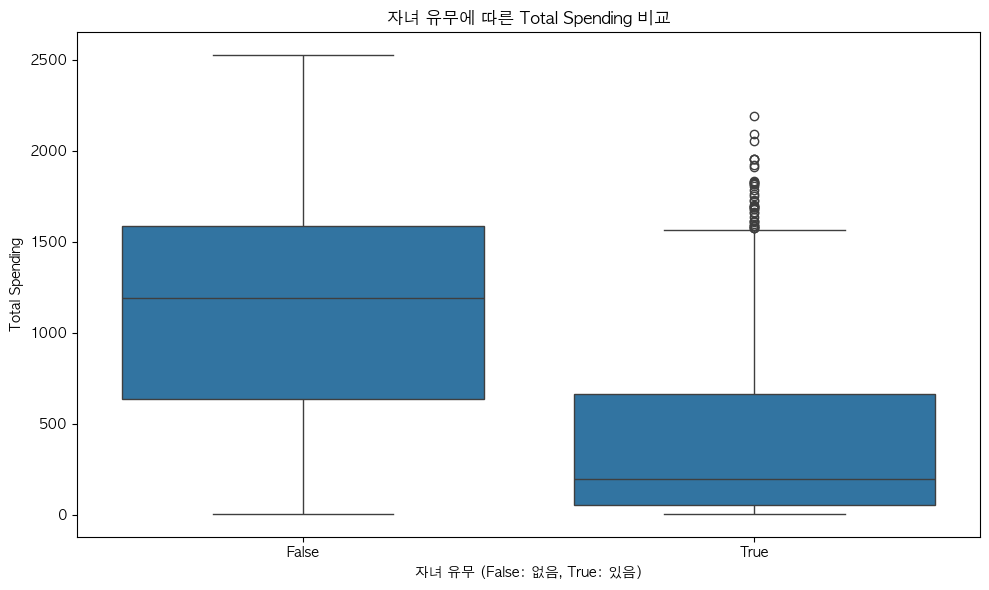

In [27]:
# TODO 3-2(c): 박스플롯 비교 시각화
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Has_Children', y='Total_Spending', data=df, ax=ax)
ax.set_title('자녀 유무에 따른 Total Spending 비교')
ax.set_xlabel('자녀 유무 (False: 없음, True: 있음)')
ax.set_ylabel('Total Spending')
plt.tight_layout()
plt.show()

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [28]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
diff = wines - meat
t_stat, p_value = stats.ttest_rel(wines, meat)
cohen_d = diff.mean() / diff.std(ddof=1)
print(f"대응표본 t-검정 결과: t-stat = {t_stat:.4f}, p-value = {p_value:.4f}")
print(f"Cohen's d = {cohen_d:.4f} (해석: {'작음' if abs(cohen_d) < 0.2 else '중간' if abs(cohen_d) < 0.5 else '큼'})")  

대응표본 t-검정 결과: t-stat = 23.0929, p-value = 0.0000
Cohen's d = 0.4884 (해석: 중간)


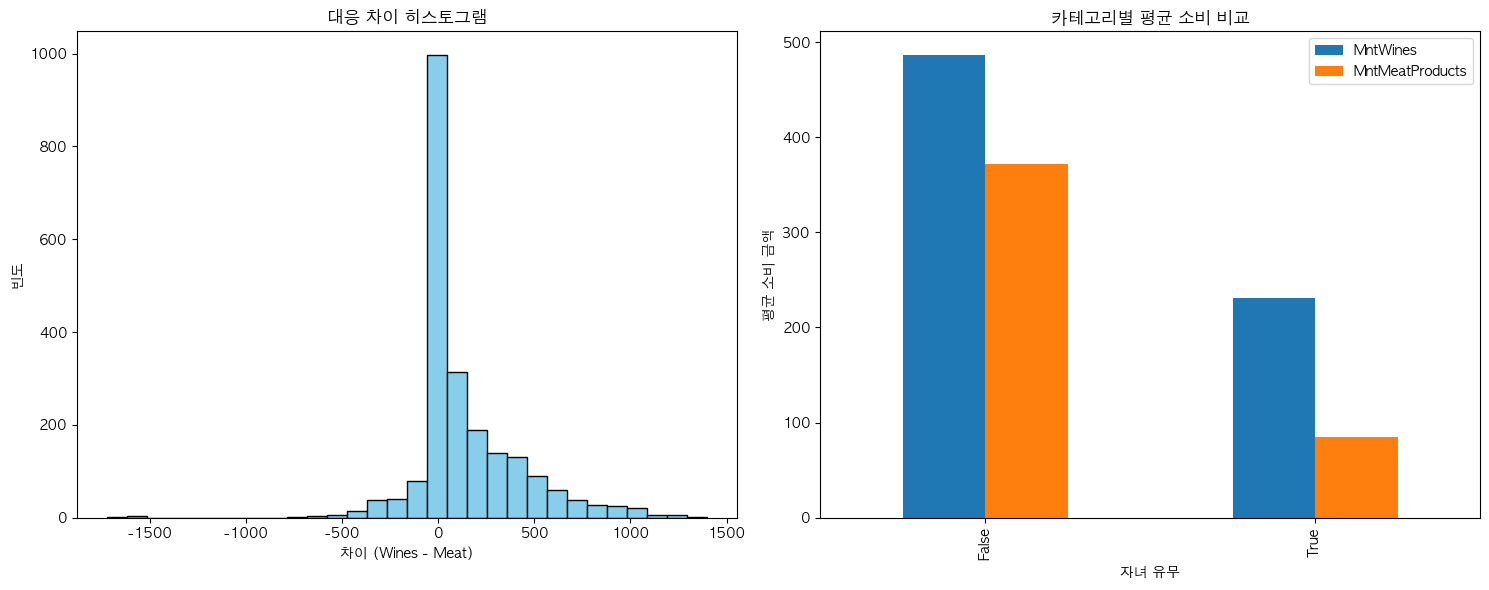

In [29]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(diff, bins=30, color='skyblue', edgecolor='black')
axes[0].set_xlabel('차이 (Wines - Meat)')
axes[0].set_ylabel('빈도')
axes[0].set_title('대응 차이 히스토그램')

category_means = df.groupby('Has_Children')[['MntWines', 'MntMeatProducts']].mean()
category_means.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('자녀 유무')
axes[1].set_ylabel('평균 소비 금액')
axes[1].set_title('카테고리별 평균 소비 비교')

plt.tight_layout()
plt.show()

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [30]:
power_analysis = TTestIndPower()

# TODO 3-4(a): 문제 3-2 기준 검정력 계산
effect_size = proportion_effectsize(cohen_d, 0)
alpha = 0.05
power = power_analysis.solve_power(effect_size=effect_size, nobs1=len(no_child), alpha=alpha, ratio=len(yes_child)/len(no_child), alternative='two-sided')
print(f"문제 3-2 검정력: {power:.4f}")

# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정
small_effect_size = 0.2
required_n = power_analysis.solve_power(effect_size=small_effect_size, alpha=alpha, power=0.8, ratio=1.0, alternative='two-sided')
print(f"작은 효과(d=0.2) 탐지에 필요한 표본 크기: {required_n:.0f}")

문제 3-2 검정력: 1.0000
작은 효과(d=0.2) 탐지에 필요한 표본 크기: 393


---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [31]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)
shapiro_results = {}
for group in edu_groups:
    group_data = df[df['Education_Group'] == group]['Total_Spending']
    stat, p = stats.shapiro(group_data)
    shapiro_results[group] = (stat, p)
    print(f"{group} 그룹: Shapiro-Wilk stat={stat:.4f}, p-value={p:.4f} -> {'정규성 만족' if p > 0.05 else '정규성 불만족'}")
# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
use_welch = None
group_data = [df[df['Education_Group'] == group]['Total_Spending'] for group in edu_groups]
stat, p = stats.levene(*group_data)
use_welch = p < 0.05
print(f"Levene 등분산 검정: stat={stat:.4f}, p-value={p:.4f} -> {'등분산 불만족 (Welch 사용)' if use_welch else '등분산 만족 (일반 ANOVA)'}")

Undergraduate 그룹: Shapiro-Wilk stat=0.7605, p-value=0.0000 -> 정규성 불만족
Graduate 그룹: Shapiro-Wilk stat=0.8743, p-value=0.0000 -> 정규성 불만족
Postgraduate 그룹: Shapiro-Wilk stat=0.8765, p-value=0.0000 -> 정규성 불만족
Levene 등분산 검정: stat=13.2893, p-value=0.0000 -> 등분산 불만족 (Welch 사용)


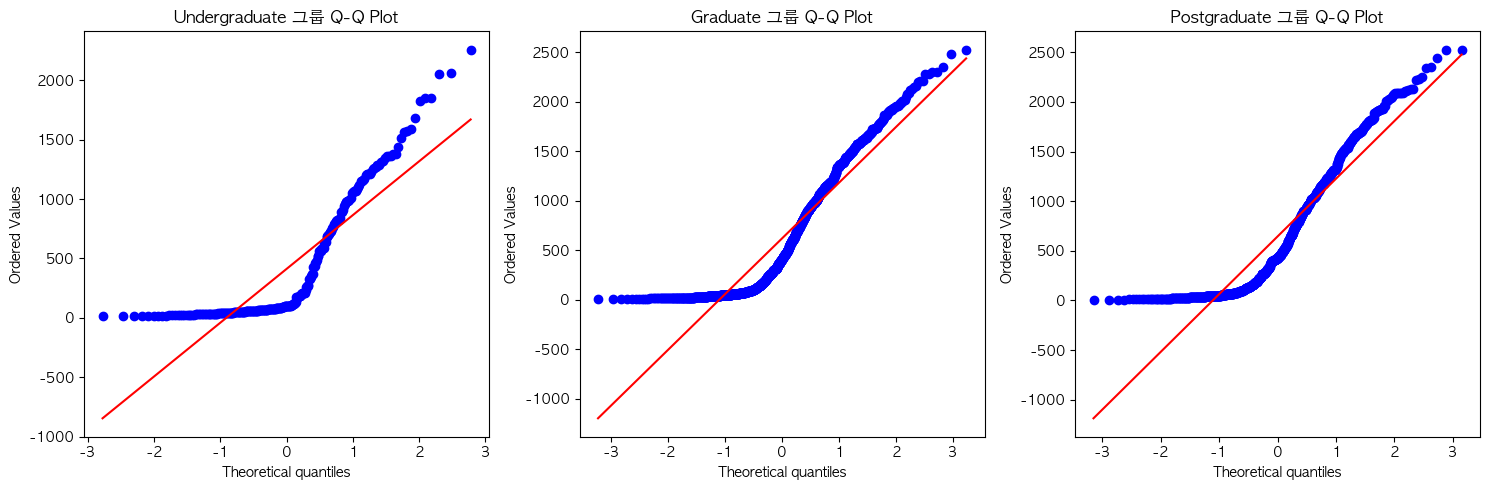

In [32]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, group in enumerate(edu_groups):
    group_data = df[df['Education_Group'] == group]['Total_Spending']
    stats.probplot(group_data, dist="norm", plot=axes[i])
    axes[i].set_title(f'{group} 그룹 Q-Q Plot')

plt.tight_layout()
plt.show()

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [33]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
if use_welch:
    anova_result = pg.welch_anova(dv='Total_Spending', between='Education_Group', data=df)
    print("Welch's ANOVA 결과:")
else:
    anova_result = pg.anova(dv='Total_Spending', between='Education_Group', data=df)
    print("일반 ANOVA 결과:")
print(anova_result)
# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)
if use_welch:
    # Welch's ANOVA 결과에서 η² 계산
    eta_squared = anova_result['np2'].iloc[0]
    print(f"η² (Welch's ANOVA): {eta_squared:.4f}")
else:
    # 일반 ANOVA 결과에서 η² 및 ω² 계산
    eta_squared = anova_result['np2'].iloc[0]
    omega_squared = anova_result['omega2'].iloc[0]
    print(f"η²: {eta_squared:.4f}, ω²: {omega_squared:.4f}")

Welch's ANOVA 결과:
            Source  ddof1       ddof2          F         p-unc     np2
0  Education_Group      2  751.708152  19.817377  4.098696e-09  0.0137
η² (Welch's ANOVA): 0.0137


In [34]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g
if not use_welch:
    tukey_result = pairwise_tukeyhsd(endog=df['Total_Spending'], groups=df['Education_Group'], alpha=0.05)
    print("Tukey HSD 결과:")
    print(tukey_result)
    # 쌍별 Cohen's d 계산
    for i in range(len(edu_groups)):
        for j in range(i+1, len(edu_groups)):
            group1 = edu_groups[i]
            group2 = edu_groups[j]
            data1 = df[df['Education_Group'] == group1]['Total_Spending']
            data2 = df[df['Education_Group'] == group2]['Total_Spending']
            pooled_std = np.sqrt((data1.std(ddof=1) ** 2 + data2.std(ddof=1) ** 2) / 2)
            cohen_d = (data1.mean() - data2.mean()) / pooled_std
            print(f"Cohen's d ({group1} vs {group2}): {cohen_d:.4f} (해석: {'작음' if abs(cohen_d) < 0.2 else '중간' if abs(cohen_d) < 0.5 else '큼'})")
else:
    gameshowell_result = pg.pairwise_gameshowell(dv='Total_Spending', between='Education_Group', data=df)
    print("Games-Howell 결과:")
    print(gameshowell_result)
    # 쌍별 Hedges' g 계산
    for i in range(len(edu_groups)):
        for j in range(i+1, len(edu_groups)):
            group1 = edu_groups[i]
            group2 = edu_groups[j]
            data1 = df[df['Education_Group'] == group1]['Total_Spending']
            data2 = df[df['Education_Group'] == group2]['Total_Spending']
            n1, n2 = len(data1), len(data2)
            var1, var2 = data1.var(ddof=1), data2.var(ddof=1)
            pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
            hedges_g = (data1.mean() - data2.mean()) / pooled_std * (1 - (3 / (4*(n1 + n2) - 9)))
            print(f"Hedges' g ({group1} vs {group2}): {hedges_g:.4f} (해석: {'작음' if abs(hedges_g) < 0.2 else '중간' if abs(hedges_g) < 0.5 else '큼'})")

Games-Howell 결과:
              A              B     mean(A)     mean(B)        diff         se  \
0      Graduate   Postgraduate  620.394316  644.791813  -24.397497  27.691976   
1      Graduate  Undergraduate  620.394316  412.254902  208.139414  36.852786   
2  Postgraduate  Undergraduate  644.791813  412.254902  232.536911  38.554847   

          T           df          pval    hedges  
0 -0.881031  1808.339544  6.523632e-01 -0.040121  
1  5.647861   425.032927  8.920634e-08  0.355688  
2  6.031328   492.811108  9.577127e-09  0.389636  
Hedges' g (Undergraduate vs Graduate): -0.3557 (해석: 중간)
Hedges' g (Undergraduate vs Postgraduate): -0.3896 (해석: 중간)
Hedges' g (Graduate vs Postgraduate): -0.0401 (해석: 작음)


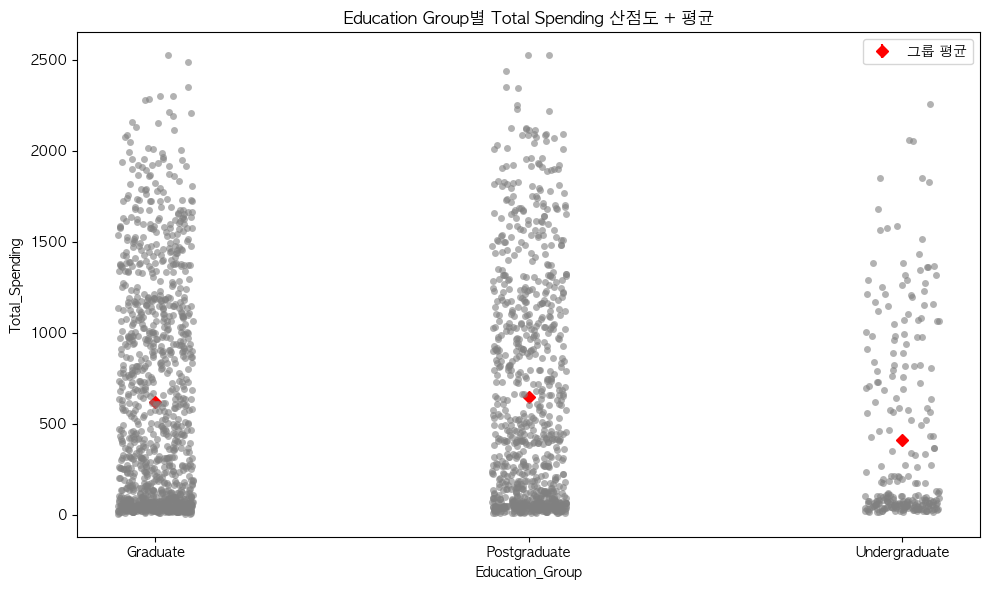

In [35]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드
fig, ax = plt.subplots(figsize=(10, 6))
sns.stripplot(x='Education_Group', y='Total_Spending', data=df, ax=ax, jitter=True, color='gray', alpha=0.6)
group_means = df.groupby('Education_Group')['Total_Spending'].mean().reset_index()
ax.errorbar(x=group_means['Education_Group'], y=group_means['Total_Spending'], yerr=0, fmt='D', color='red', label='그룹 평균')
ax.set_title('Education Group별 Total Spending 산점도 + 평균')
ax.legend()
plt.tight_layout()
plt.show()

### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [36]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
chi2_stat, p_value, dof, expected = stats.chi2_contingency(crosstab_no_margin)
print(f"카이제곱 검정 결과: chi2_stat = {chi2_stat:.4f}, p-value = {p_value:.4f}, dof = {dof}")
print("Cochran 규칙 확인")
print(f"기대 빈도:\n{expected}")
print(f"기대 빈도 중 5 미만인 셀 수: {(expected < 5).sum()}")
# TODO 4-3(b): φ (phi) 계산
phi = np.sqrt(chi2_stat / (df.shape[0] * (min(crosstab_no_margin.shape) - 1)))
print(f"φ (phi): {phi:.4f}")
# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산
success_a = crosstab_no_margin.loc['Together', True]
failure_a = crosstab_no_margin.loc['Together', False]
success_b = crosstab_no_margin.loc['Single', True]
failure_b = crosstab_no_margin.loc['Single', False]
odds_ratio = (success_a / failure_a) / (success_b / failure_b)
se_log_or = np.sqrt(1/success_a + 1/failure_a + 1/success_b + 1/failure_b)
ci_lower = np.exp(np.log(odds_ratio) - 1.96 * se_log_or)
ci_upper = np.exp(np.log(odds_ratio) + 1.96 * se_log_or)
print(f"오즈비: {odds_ratio:.4f}, 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")    

카이제곱 검정 결과: chi2_stat = 9.2368, p-value = 0.0024, dof = 1
Cochran 규칙 확인
기대 빈도:
[[ 578.10017889  215.89982111]
 [1049.89982111  392.10017889]]
기대 빈도 중 5 미만인 셀 수: 0
φ (phi): 0.0643
오즈비: 0.7396, 95% CI: [0.6105, 0.8959]


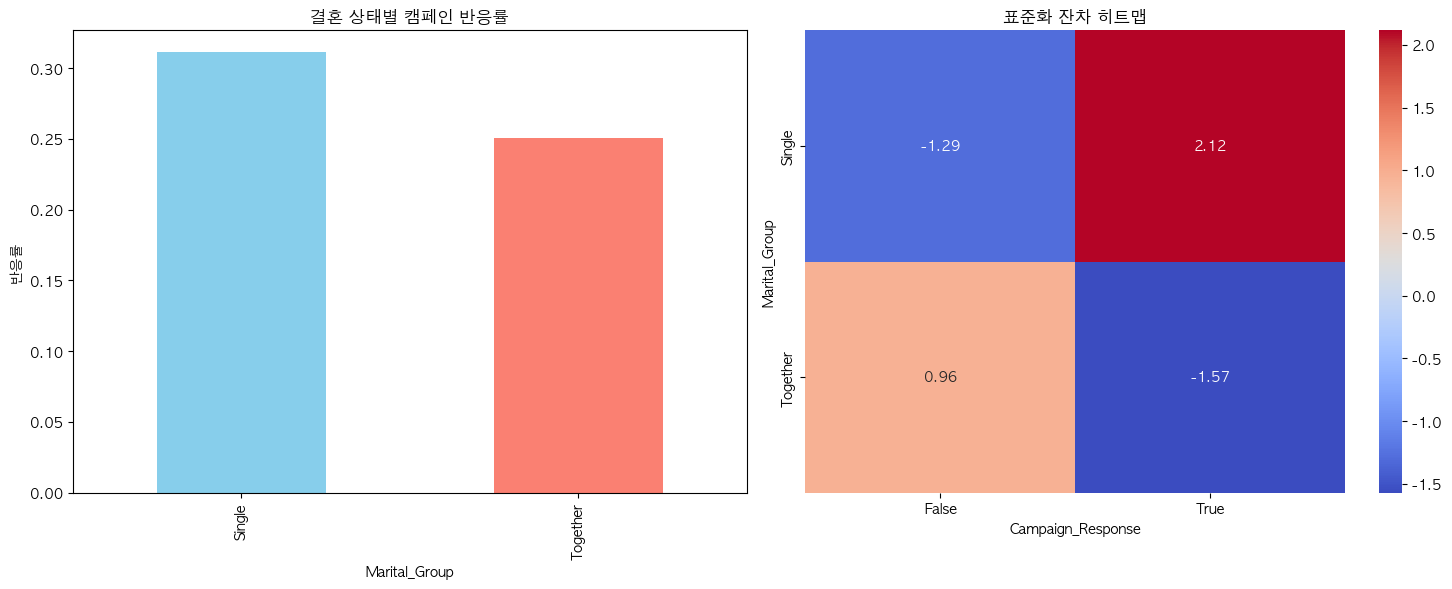

In [37]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

response_rates = crosstab_no_margin.div(crosstab_no_margin.sum(axis=1), axis=0)[True]
response_rates.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('결혼 상태별 캠페인 반응률')
axes[0].set_ylabel('반응률')

residuals = (crosstab_no_margin - expected) / np.sqrt(expected)
sns.heatmap(residuals, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[1])
axes[1].set_title('표준화 잔차 히트맵')

plt.tight_layout()
plt.show()

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [38]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
expected = np.full_like(observed, observed.sum() / len(observed))
chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)
print(f"적합도 검정 결과: chi2_stat = {chi2_stat:.4f}, p-value = {p_value:.4f}")
# TODO 4-4(b): Cohen's w 계산
cohen_w = np.sqrt(chi2_stat / observed.sum())
print(f"Cohen's w: {cohen_w:.4f} (해석: {'작음' if cohen_w < 0.1 else '중간' if cohen_w < 0.3 else '큼'})")

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1.4901161193847656e-08, but the percent differences are:
3.564681139272092e-05

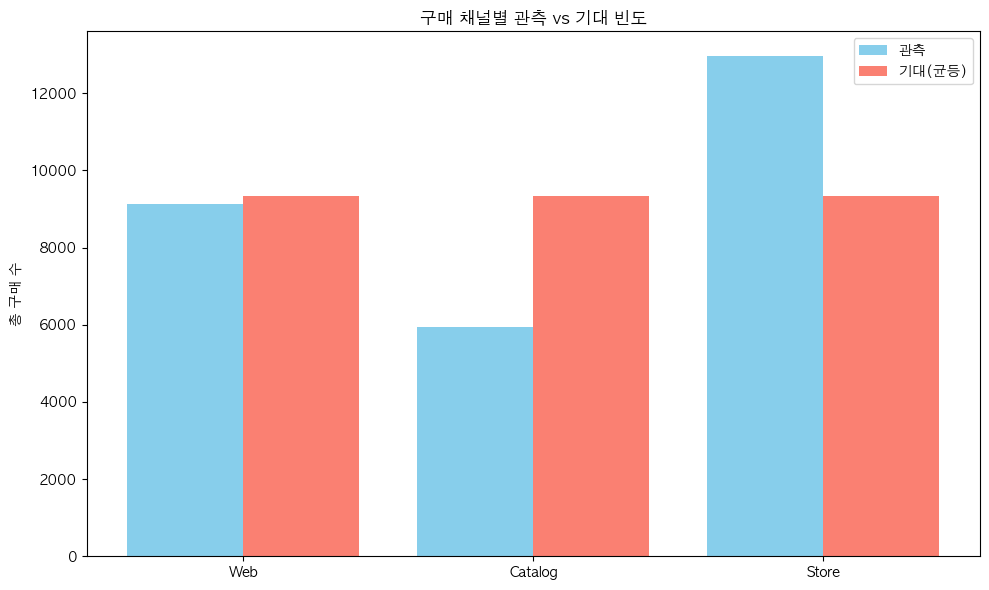

In [39]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(channel_names))
ax.bar(x - 0.2, observed, width=0.4, label='관측', color='skyblue')
ax.bar(x + 0.2, expected, width=0.4, label='기대(균등)', color='salmon')
ax.set_xticks(x)
ax.set_xticklabels(channel_names)
ax.set_title('구매 채널별 관측 vs 기대 빈도')
ax.set_ylabel('총 구매 수')
ax.legend()
plt.tight_layout()
plt.show()

---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [40]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산
pearson_corr = df[corr_vars].corr(method='pearson')
spearman_corr = df[corr_vars].corr(method='spearman')
print("Pearson 상관행렬:")
print(pearson_corr)
print("\nSpearman 상관행렬:")
print(spearman_corr)
# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)
for i in range(len(corr_vars)):
    for j in range(i+1, len(corr_vars)):
        var1 = corr_vars[i]
        var2 = corr_vars[j]
        r, p = stats.pearsonr(df[var1], df[var2])
        print(f"Pearson 상관 검정: {var1} vs {var2} -> r={r:.4f}, p-value={p:.4f}")

Pearson 상관행렬:
                     Income       Age  Total_Spending  Total_Purchases  \
Income             1.000000  0.198835        0.789375         0.738647   
Age                0.198835  1.000000        0.113618         0.173004   
Total_Spending     0.789375  0.113618        1.000000         0.821091   
Total_Purchases    0.738647  0.173004        0.821091         1.000000   
NumWebVisitsMonth -0.646382 -0.117498       -0.499909        -0.426734   
Recency            0.007829  0.019396        0.020842         0.006426   

                   NumWebVisitsMonth   Recency  
Income                     -0.646382  0.007829  
Age                        -0.117498  0.019396  
Total_Spending             -0.499909  0.020842  
Total_Purchases            -0.426734  0.006426  
NumWebVisitsMonth           1.000000 -0.021850  
Recency                    -0.021850  1.000000  

Spearman 상관행렬:
                     Income       Age  Total_Spending  Total_Purchases  \
Income             1.000000  0.216

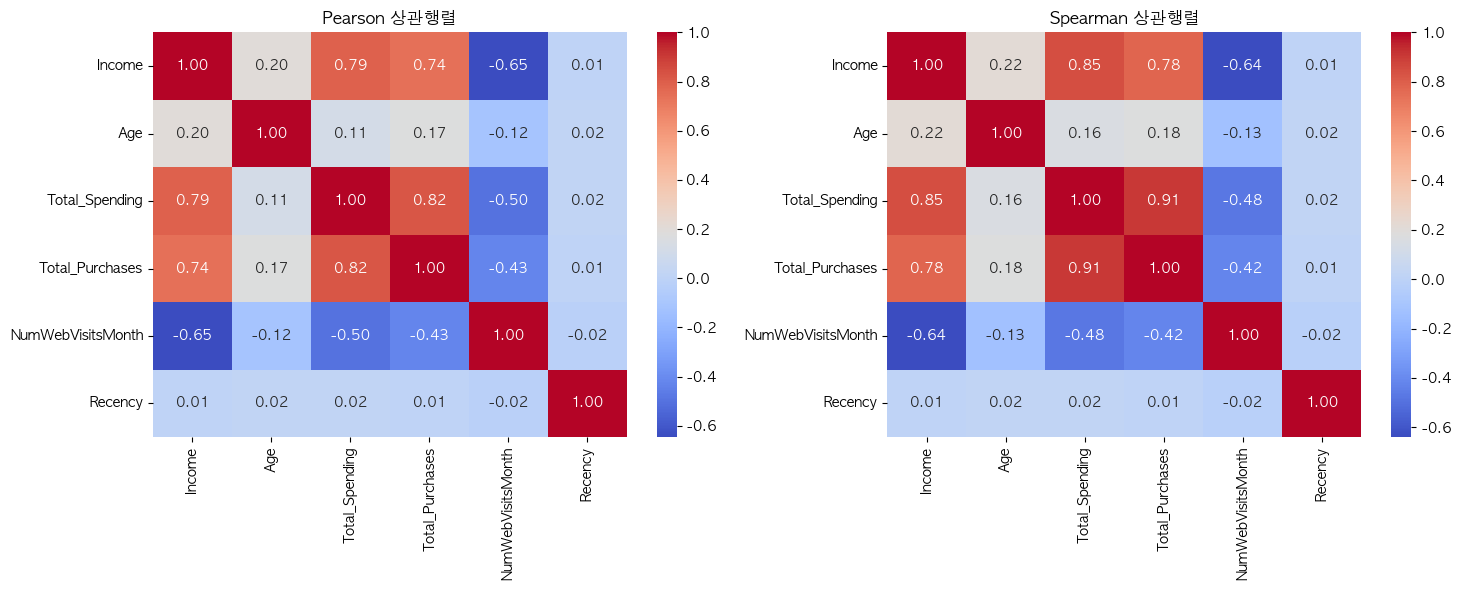

In [48]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[0])
axes[0].set_title('Pearson 상관행렬')
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[1])
axes[1].set_title('Spearman 상관행렬')
plt.tight_layout()
plt.show()

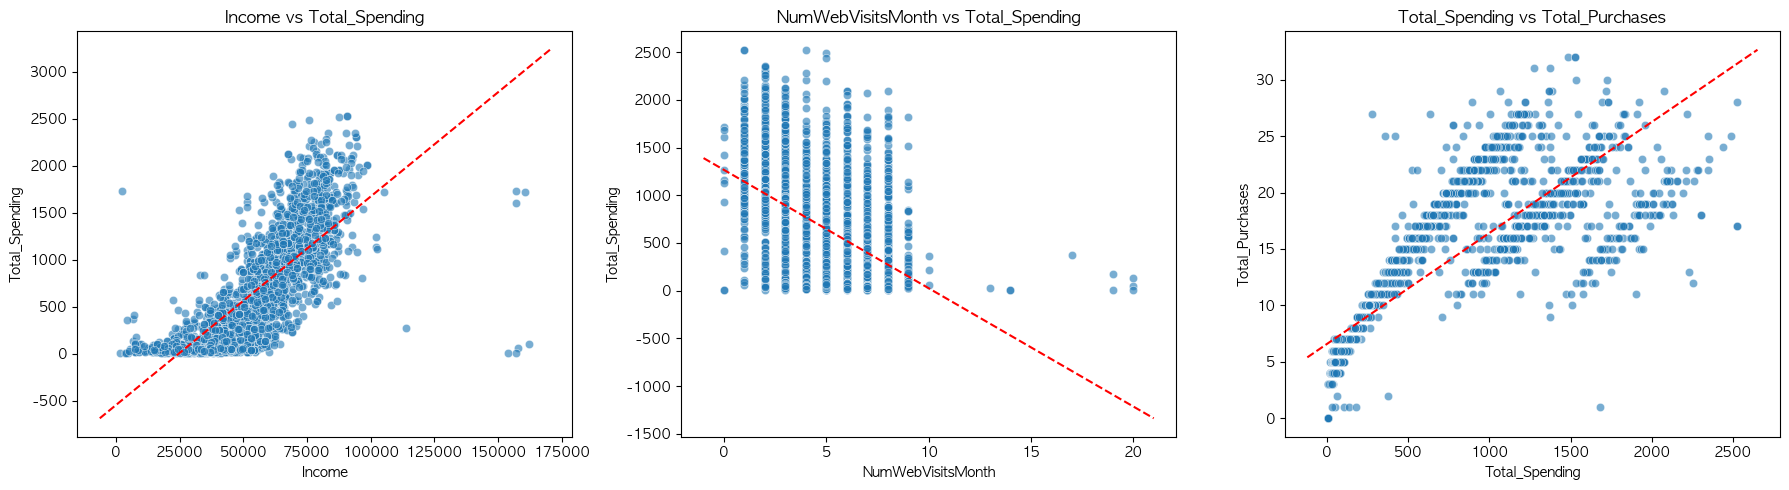

In [49]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요
target_pairs = [('Income', 'Total_Spending'), ('NumWebVisitsMonth', 'Total_Spending'), ('Total_Spending', 'Total_Purchases')]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (x_var, y_var) in enumerate(target_pairs):
    sns.scatterplot(x=df[x_var], y=df[y_var], ax=axes[i], alpha=0.6)
    # 추세선 계산
    slope, intercept = np.polyfit(df[x_var], df[y_var], 1)
    x_vals = np.array(axes[i].get_xlim())
    y_vals = intercept + slope * x_vals
    axes[i].plot(x_vals, y_vals, color='red', linestyle='--')
    axes[i].set_title(f'{x_var} vs {y_var}')
plt.tight_layout()
plt.show()

### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [52]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b

# TODO 5-2(a): z-비율검정 + 효과 크기 계산
p_pool = (conv_a + conv_b) / (n_a + n_b)
se_pool = np.sqrt(p_pool * (1 - p_pool) * (1/n_a + 1/n_b))
z_stat = (rate_b - rate_a) / se_pool
p_value = 2 * stats.norm.sf(abs(z_stat))
print(f"z-비율검정 결과: z-stat = {z_stat:.4f}, p-value = {p_value:.4f}")
effect_size = rate_b - rate_a
print(f"효과 크기 (차이): {effect_size:.4f}")
# TODO 5-2(b): Cohen's h 효과 크기
cohen_h = 2 * np.arcsin(np.sqrt(rate_b)) - 2 * np.arcsin(np.sqrt(rate_a))
print(f"Cohen's h 효과 크기: {cohen_h:.4f}")    
# TODO 5-2(c): Wilson 신뢰구간
def wilson_ci(successes, n, alpha=0.05):
    if n == 0:
        return (0, 0)
    z = stats.norm.ppf(1 - alpha / 2)
    p_hat = successes / n
    denominator = 1 + z**2 / n
    center = (p_hat + z**2 / (2 * n)) / denominator
    margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * n)) / n) / denominator
    return center - margin, center + margin
ci_a = wilson_ci(conv_a, n_a)
ci_b = wilson_ci(conv_b, n_b)
print(f"Prior Response = 0 그룹 Wilson CI: [{ci_a[0]:.4f}, {ci_a[1]:.4f}]")
print(f"Prior Response ≥ 1 그룹 Wilson CI: [{ci_b[0]:.4f}, {ci_b[1]:.4f}]")

z-비율검정 결과: z-stat = 17.4357, p-value = 0.0000
효과 크기 (차이): 0.3246
Cohen's h 효과 크기: 0.8016
Prior Response = 0 그룹 Wilson CI: [0.0704, 0.0960]
Prior Response ≥ 1 그룹 Wilson CI: [0.3631, 0.4523]


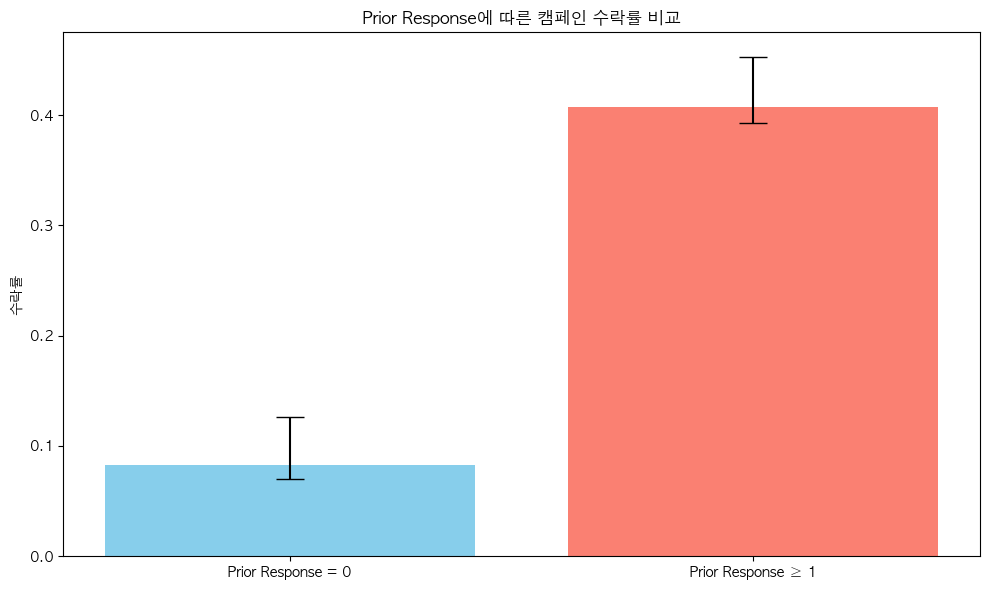

In [53]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(['Prior Response = 0', 'Prior Response ≥ 1'], [rate_a, rate_b], yerr=[(rate_a - ci_a[0], ci_a[1] - rate_a), (rate_b - ci_b[0], ci_b[1] - rate_b)], capsize=10, color=['skyblue', 'salmon'])
ax.set_title('Prior Response에 따른 캠페인 수락률 비교')
ax.set_ylabel('수락률')
plt.tight_layout()
plt.show()

> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [55]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산
cohen_h = 2 * np.arcsin(np.sqrt(target_rate)) - 2 * np.arcsin(np.sqrt(baseline_rate))
print(f"Cohen's h 효과 크기: {cohen_h:.4f}")
# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)
power_analysis = NormalIndPower()
required_n = power_analysis.solve_power(effect_size=cohen_h, alpha=0.05, power=0.8, alternative='larger')
print(f"필요 표본 크기: {required_n:.0f}")

Cohen's h 효과 크기: 0.0547
필요 표본 크기: 4138


---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [56]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화
group_cols = ['Income_Group', 'Marital_Group', 'Education_Group']
summary_stats = df.groupby(group_cols)['Total_Spending'].agg(['mean', 'std', 'count'])
print("그룹별 Total Spending 요약")
print(summary_stats)

그룹별 Total Spending 요약
                                                   mean         std  count
Income_Group Marital_Group Education_Group                                
Low          Single        Graduate          103.619403  123.957657    134
                           Postgraduate       94.756098  117.601394     82
                           Undergraduate      68.341463   52.076199     41
             Together      Graduate           94.032653  139.750447    245
                           Postgraduate      101.459459  116.173303    148
                           Undergraduate      92.333333  124.189809     96
Mid          Single        Graduate          466.330769  376.620085    130
                           Postgraduate      479.601626  392.628192    123
                           Undergraduate     457.950000  440.465002     20
             Together      Graduate          469.933333  351.407247    225
                           Postgraduate      424.158654  343.502982    208
   

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [ ]:
# TODO C-2: 비즈니스 제안서 작성

---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛